In [2]:
def create_contexts_target(corpus,window_size=1):
    target = corpus[window_size:-window_size] # target이 될 수 있는 놈들
    contexts=[]
    for idx in range(window_size,len(corpus)-window_size):
        cs = []
        for t in range(-window_size,window_size+1): # idx를 원점으로 봤을 때 상대적인 위치의 indexing

            if t == 0: # 자기 자신을 보는 경우
                continue
            cs.append(corpus[idx+t]) # 그 위치의 단어 ID를 추가, 즉 idx-window_size,idx+window_size까지의 단어 ID들을 추가한다.
        contexts.append(cs)
    return np.array(contexts),np.array(target)

In [3]:
import sys
sys.path.append('..')
import numpy as np

def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

text = "You say goodbye and I say hello."
corpus,word_to_id,id_to_word = preprocess(text)
#print(corpus)
#print(id_to_word)
contexts,target = create_contexts_target(corpus)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [4]:
def convert_one_hot(corpus, vocab_size):

    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [5]:
context,target= create_contexts_target(corpus)
vocab_size = len(corpus)

target = convert_one_hot(target,vocab_size)
context = convert_one_hot(context,vocab_size)
print(target)
print(context)

[[0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]]
[[[1 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]]

 [[0 1 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]]

 [[0 0 1 0 0 0 0 0]
  [0 0 0 0 1 0 0 0]]

 [[0 0 0 1 0 0 0 0]
  [0 1 0 0 0 0 0 0]]

 [[0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0]]

 [[0 1 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0]]]


In [6]:
import sys
sys.path.append('..')
import numpy as np

class SimpleCBOW:
    def __init__(self,vocab_size,hidden_size):
        V,H = vocab_size,hidden_size

        # Init Weight
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(H,V).astype('f')

        # Create layer
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        # 이 구현에서 두 input layer는 같은 W_in값을 갖게 된다. 왜냐하면 backprop이 동일한 초기 
        # W_in에 대해 동일한 값을 계속하여 바꾸기 때문
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # Listing all weights and grads
        layers = [self.in_layer0,self.in_layer1,self.out_layer]
        self.params, self.grads = [],[]
        # 모든 layer에 있는 parameter들을 하나의 리스트에 저장
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # save distributional representation of word in instance variable
        self.word_vecs = W_in

    def forward(self,contexts,target):
        h0 = self.in_layer0.forward(contexts[:,0])
        # contexts[:,0] 맥락 단어 2개 중 앞단어'들', one-hot encoding이 여러개 붙어있는 것이므로 2차원임.
        h1 = self.in_layer1.forward(contexts[:,1])
        # contexts[:,1] 맥락 단어 2개 중 뒷단어'들
        h = (h0+h1)*0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score,target)
        return loss

    def backward(self,dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [7]:
import numpy
import time
import matplotlib.pyplot as plt
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0
    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0
        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]
            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]
                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1
                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0
            self.current_epoch += 1
    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()

class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0
    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치
        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t
    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0
        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)
                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1
                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0
            self.current_epoch += 1
    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()

def remove_duplicate(params, grads):
    params, grads = params[:], grads[:]  # copy list
    while True:
        find_flg = False
        L = len(params)
        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                if find_flg: break
            if find_flg: break
        if not find_flg: break
    return params, grads

class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None
    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out
    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)
        loss = cross_entropy_error(self.y, self.t)
        return loss
    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size
        return dx

class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None
    def forward(self, x):
        self.out = softmax(x)
        return self.out
    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx

def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))
    return x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)  
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [8]:
#from simple_cbow import SimpleCBOW
# Set hyperparams
window_size = 1
hidden_size = 10
batch_size = 3
max_epoch = 1000

# set corpus
text = 'You say goodbye and I say hello.해외의 미디어 그룹들이 기후변화에 대응하며 ESG(환경・사회・지배구조) 경영을 강조하는 모습을 보면서, 이와 관련된 소비자들의 니즈도 변화하고 있습니다. 특히, 영국의 BBC와 패션잡지 엘르, 그리고 다른 일간지들의 행보를 고려하면 다음과 같은 소비자들의 니즈가 강조될 것입니다: 친환경 자동차 및 교통수단에 대한 수요 상승: BBC의 경우, 탄소중립을 위한 계획 중 일환으로 업무용 차량을 전기차로 전환하고 직원의 교통 이용에 따른 온실가스 배출을 줄이는 노력을 하고 있습니다. 이러한 노력은 친환경 자동차 및 교통수단에 대한 수요를 높일 수 있습니다. 친환경 모빌리티 서비스 수요 상승: 미디어 기업이 친환경 교통에 대한 노력을 통해 소개하는 정보는 소비자들에게 친환경 모빌리티 서비스에 대한 관심을 높일 것입니다. 공공 교통, 자전거 공유, 전기 스쿠터 등 친환경 모빌리티 서비스의 수요가 증가할 것으로 예상됩니다. 지속 가능한 미디어 컨텐츠 선호도 증가: 뉴스, 드라마, 다큐멘터리 등을 통해 환경 보호 및 기후 변화에 대한 내용을 다루는 미디어 컨텐츠에 대한 수요가 높아질 것입니다. 소비자들은 환경 문제에 대한 인식을 높이고, 기업들의 노력을 지지하는 컨텐츠를 선호할 것입니다. 모피 없는 패션에 대한 선호도 증가: 엘르가 국제판에서 모피 콘텐츠를 금지하는 결정은 동물복지와 지속 가능한 패션 산업을 지원하려는 노력으로 해석될 수 있습니다. 이는 소비자들이 동물 친화적이며 지속 가능한 소재를 사용한 패션에 대한 선호도를 높일 수 있습니다. 탄소중립 및 ESG에 대한 기업 투자 선호도 증가: 뉴욕타임즈, 가디언 등의 일간지들이 기후위기 대응에 적극 참여하고 있는 모습은 소비자들에게 기업의 탄소중립 및 ESG 경영에 대한 신뢰를 높일 것입니다. 이에 따라 소비자들은 이러한 가치를 가진 기업에 투자하는 것을 선호할 가능성이 있습니다. 종합적으로 해외에서의 미디어 기업들의 환경에 대한 적극적인 대응은 친환경 제품 및 서비스에 대한 수요 증가와 함께, 지속 가능한 라이프스타일과 기업에 대한 높은 기대를 반영하고 있습니다.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| 에폭 1 |  반복 1 / 87 | 시간 0[s] | 손실 5.18
| 에폭 1 |  반복 21 / 87 | 시간 0[s] | 손실 5.18
| 에폭 1 |  반복 41 / 87 | 시간 0[s] | 손실 5.18
| 에폭 1 |  반복 61 / 87 | 시간 0[s] | 손실 5.18
| 에폭 1 |  반복 81 / 87 | 시간 0[s] | 손실 5.18
| 에폭 2 |  반복 1 / 87 | 시간 0[s] | 손실 5.18
| 에폭 2 |  반복 21 / 87 | 시간 0[s] | 손실 5.17
| 에폭 2 |  반복 41 / 87 | 시간 0[s] | 손실 5.17
| 에폭 2 |  반복 61 / 87 | 시간 0[s] | 손실 5.17
| 에폭 2 |  반복 81 / 87 | 시간 0[s] | 손실 5.17
| 에폭 3 |  반복 1 / 87 | 시간 0[s] | 손실 5.17
| 에폭 3 |  반복 21 / 87 | 시간 0[s] | 손실 5.17
| 에폭 3 |  반복 41 / 87 | 시간 0[s] | 손실 5.17
| 에폭 3 |  반복 61 / 87 | 시간 0[s] | 손실 5.17
| 에폭 3 |  반복 81 / 87 | 시간 0[s] | 손실 5.16
| 에폭 4 |  반복 1 / 87 | 시간 0[s] | 손실 5.16
| 에폭 4 |  반복 21 / 87 | 시간 0[s] | 손실 5.16
| 에폭 4 |  반복 41 / 87 | 시간 0[s] | 손실 5.15
| 에폭 4 |  반복 61 / 87 | 시간 0[s] | 손실 5.15
| 에폭 4 |  반복 81 / 87 | 시간 0[s] | 손실 5.14
| 에폭 5 |  반복 1 / 87 | 시간 0[s] | 손실 5.14
| 에폭 5 |  반복 21 / 87 | 시간 0[s] | 손실 5.14
| 에폭 5 |  반복 41 / 87 | 시간 0[s] | 손실 5.13
| 에폭 5 |  반복 61 / 87 | 시간 0[s] | 손실 5.11
| 에폭 5 |  반복 81 / 87 

| 에폭 54 |  반복 41 / 87 | 시간 0[s] | 손실 2.12
| 에폭 54 |  반복 61 / 87 | 시간 0[s] | 손실 2.35
| 에폭 54 |  반복 81 / 87 | 시간 0[s] | 손실 2.06
| 에폭 55 |  반복 1 / 87 | 시간 0[s] | 손실 2.49
| 에폭 55 |  반복 21 / 87 | 시간 0[s] | 손실 2.26
| 에폭 55 |  반복 41 / 87 | 시간 0[s] | 손실 2.22
| 에폭 55 |  반복 61 / 87 | 시간 0[s] | 손실 2.22
| 에폭 55 |  반복 81 / 87 | 시간 0[s] | 손실 2.11
| 에폭 56 |  반복 1 / 87 | 시간 0[s] | 손실 1.94
| 에폭 56 |  반복 21 / 87 | 시간 0[s] | 손실 2.06
| 에폭 56 |  반복 41 / 87 | 시간 0[s] | 손실 2.32
| 에폭 56 |  반복 61 / 87 | 시간 0[s] | 손실 1.95
| 에폭 56 |  반복 81 / 87 | 시간 0[s] | 손실 2.34
| 에폭 57 |  반복 1 / 87 | 시간 0[s] | 손실 1.85
| 에폭 57 |  반복 21 / 87 | 시간 0[s] | 손실 1.97
| 에폭 57 |  반복 41 / 87 | 시간 0[s] | 손실 2.14
| 에폭 57 |  반복 61 / 87 | 시간 0[s] | 손실 2.20
| 에폭 57 |  반복 81 / 87 | 시간 0[s] | 손실 2.05
| 에폭 58 |  반복 1 / 87 | 시간 0[s] | 손실 2.34
| 에폭 58 |  반복 21 / 87 | 시간 0[s] | 손실 1.99
| 에폭 58 |  반복 41 / 87 | 시간 0[s] | 손실 1.91
| 에폭 58 |  반복 61 / 87 | 시간 0[s] | 손실 2.33
| 에폭 58 |  반복 81 / 87 | 시간 0[s] | 손실 2.13
| 에폭 59 |  반복 1 / 87 | 시간 0[s] | 손실 2.

| 에폭 104 |  반복 61 / 87 | 시간 1[s] | 손실 0.87
| 에폭 104 |  반복 81 / 87 | 시간 1[s] | 손실 0.98
| 에폭 105 |  반복 1 / 87 | 시간 1[s] | 손실 1.12
| 에폭 105 |  반복 21 / 87 | 시간 1[s] | 손실 0.82
| 에폭 105 |  반복 41 / 87 | 시간 1[s] | 손실 0.86
| 에폭 105 |  반복 61 / 87 | 시간 1[s] | 손실 1.02
| 에폭 105 |  반복 81 / 87 | 시간 1[s] | 손실 0.97
| 에폭 106 |  반복 1 / 87 | 시간 1[s] | 손실 0.92
| 에폭 106 |  반복 21 / 87 | 시간 1[s] | 손실 0.97
| 에폭 106 |  반복 41 / 87 | 시간 1[s] | 손실 0.84
| 에폭 106 |  반복 61 / 87 | 시간 1[s] | 손실 0.86
| 에폭 106 |  반복 81 / 87 | 시간 1[s] | 손실 0.95
| 에폭 107 |  반복 1 / 87 | 시간 1[s] | 손실 1.11
| 에폭 107 |  반복 21 / 87 | 시간 1[s] | 손실 0.88
| 에폭 107 |  반복 41 / 87 | 시간 1[s] | 손실 0.87
| 에폭 107 |  반복 61 / 87 | 시간 1[s] | 손실 0.84
| 에폭 107 |  반복 81 / 87 | 시간 1[s] | 손실 0.97
| 에폭 108 |  반복 1 / 87 | 시간 1[s] | 손실 0.85
| 에폭 108 |  반복 21 / 87 | 시간 1[s] | 손실 0.98
| 에폭 108 |  반복 41 / 87 | 시간 1[s] | 손실 0.85
| 에폭 108 |  반복 61 / 87 | 시간 1[s] | 손실 0.79
| 에폭 108 |  반복 81 / 87 | 시간 1[s] | 손실 0.88
| 에폭 109 |  반복 1 / 87 | 시간 1[s] | 손실 1.02
| 에폭 109 |  반복 2

| 에폭 156 |  반복 21 / 87 | 시간 1[s] | 손실 0.37
| 에폭 156 |  반복 41 / 87 | 시간 1[s] | 손실 0.34
| 에폭 156 |  반복 61 / 87 | 시간 1[s] | 손실 0.37
| 에폭 156 |  반복 81 / 87 | 시간 1[s] | 손실 0.30
| 에폭 157 |  반복 1 / 87 | 시간 1[s] | 손실 0.36
| 에폭 157 |  반복 21 / 87 | 시간 1[s] | 손실 0.35
| 에폭 157 |  반복 41 / 87 | 시간 1[s] | 손실 0.32
| 에폭 157 |  반복 61 / 87 | 시간 1[s] | 손실 0.30
| 에폭 157 |  반복 81 / 87 | 시간 1[s] | 손실 0.42
| 에폭 158 |  반복 1 / 87 | 시간 1[s] | 손실 0.39
| 에폭 158 |  반복 21 / 87 | 시간 1[s] | 손실 0.32
| 에폭 158 |  반복 41 / 87 | 시간 1[s] | 손실 0.27
| 에폭 158 |  반복 61 / 87 | 시간 1[s] | 손실 0.38
| 에폭 158 |  반복 81 / 87 | 시간 1[s] | 손실 0.35
| 에폭 159 |  반복 1 / 87 | 시간 1[s] | 손실 0.31
| 에폭 159 |  반복 21 / 87 | 시간 1[s] | 손실 0.27
| 에폭 159 |  반복 41 / 87 | 시간 1[s] | 손실 0.27
| 에폭 159 |  반복 61 / 87 | 시간 1[s] | 손실 0.34
| 에폭 159 |  반복 81 / 87 | 시간 1[s] | 손실 0.42
| 에폭 160 |  반복 1 / 87 | 시간 1[s] | 손실 0.36
| 에폭 160 |  반복 21 / 87 | 시간 1[s] | 손실 0.42
| 에폭 160 |  반복 41 / 87 | 시간 1[s] | 손실 0.23
| 에폭 160 |  반복 61 / 87 | 시간 1[s] | 손실 0.32
| 에폭 160 |  반복 

| 에폭 205 |  반복 81 / 87 | 시간 2[s] | 손실 0.16
| 에폭 206 |  반복 1 / 87 | 시간 2[s] | 손실 0.28
| 에폭 206 |  반복 21 / 87 | 시간 2[s] | 손실 0.09
| 에폭 206 |  반복 41 / 87 | 시간 2[s] | 손실 0.17
| 에폭 206 |  반복 61 / 87 | 시간 2[s] | 손실 0.15
| 에폭 206 |  반복 81 / 87 | 시간 2[s] | 손실 0.16
| 에폭 207 |  반복 1 / 87 | 시간 2[s] | 손실 0.12
| 에폭 207 |  반복 21 / 87 | 시간 2[s] | 손실 0.15
| 에폭 207 |  반복 41 / 87 | 시간 2[s] | 손실 0.12
| 에폭 207 |  반복 61 / 87 | 시간 2[s] | 손실 0.14
| 에폭 207 |  반복 81 / 87 | 시간 2[s] | 손실 0.15
| 에폭 208 |  반복 1 / 87 | 시간 2[s] | 손실 0.17
| 에폭 208 |  반복 21 / 87 | 시간 2[s] | 손실 0.19
| 에폭 208 |  반복 41 / 87 | 시간 2[s] | 손실 0.15
| 에폭 208 |  반복 61 / 87 | 시간 2[s] | 손실 0.14
| 에폭 208 |  반복 81 / 87 | 시간 2[s] | 손실 0.09
| 에폭 209 |  반복 1 / 87 | 시간 2[s] | 손실 0.08
| 에폭 209 |  반복 21 / 87 | 시간 2[s] | 손실 0.13
| 에폭 209 |  반복 41 / 87 | 시간 2[s] | 손실 0.18
| 에폭 209 |  반복 61 / 87 | 시간 2[s] | 손실 0.13
| 에폭 209 |  반복 81 / 87 | 시간 2[s] | 손실 0.14
| 에폭 210 |  반복 1 / 87 | 시간 2[s] | 손실 0.06
| 에폭 210 |  반복 21 / 87 | 시간 2[s] | 손실 0.12
| 에폭 210 |  반복 4

| 에폭 256 |  반복 81 / 87 | 시간 2[s] | 손실 0.04
| 에폭 257 |  반복 1 / 87 | 시간 2[s] | 손실 0.16
| 에폭 257 |  반복 21 / 87 | 시간 2[s] | 손실 0.08
| 에폭 257 |  반복 41 / 87 | 시간 2[s] | 손실 0.11
| 에폭 257 |  반복 61 / 87 | 시간 2[s] | 손실 0.05
| 에폭 257 |  반복 81 / 87 | 시간 2[s] | 손실 0.05
| 에폭 258 |  반복 1 / 87 | 시간 2[s] | 손실 0.07
| 에폭 258 |  반복 21 / 87 | 시간 2[s] | 손실 0.06
| 에폭 258 |  반복 41 / 87 | 시간 2[s] | 손실 0.04
| 에폭 258 |  반복 61 / 87 | 시간 2[s] | 손실 0.12
| 에폭 258 |  반복 81 / 87 | 시간 2[s] | 손실 0.06
| 에폭 259 |  반복 1 / 87 | 시간 2[s] | 손실 0.13
| 에폭 259 |  반복 21 / 87 | 시간 2[s] | 손실 0.05
| 에폭 259 |  반복 41 / 87 | 시간 2[s] | 손실 0.05
| 에폭 259 |  반복 61 / 87 | 시간 2[s] | 손실 0.14
| 에폭 259 |  반복 81 / 87 | 시간 2[s] | 손실 0.06
| 에폭 260 |  반복 1 / 87 | 시간 2[s] | 손실 0.12
| 에폭 260 |  반복 21 / 87 | 시간 2[s] | 손실 0.05
| 에폭 260 |  반복 41 / 87 | 시간 2[s] | 손실 0.14
| 에폭 260 |  반복 61 / 87 | 시간 2[s] | 손실 0.06
| 에폭 260 |  반복 81 / 87 | 시간 2[s] | 손실 0.07
| 에폭 261 |  반복 1 / 87 | 시간 2[s] | 손실 0.02
| 에폭 261 |  반복 21 / 87 | 시간 2[s] | 손실 0.06
| 에폭 261 |  반복 4

| 에폭 307 |  반복 61 / 87 | 시간 3[s] | 손실 0.07
| 에폭 307 |  반복 81 / 87 | 시간 3[s] | 손실 0.03
| 에폭 308 |  반복 1 / 87 | 시간 3[s] | 손실 0.12
| 에폭 308 |  반복 21 / 87 | 시간 3[s] | 손실 0.06
| 에폭 308 |  반복 41 / 87 | 시간 3[s] | 손실 0.05
| 에폭 308 |  반복 61 / 87 | 시간 3[s] | 손실 0.03
| 에폭 308 |  반복 81 / 87 | 시간 3[s] | 손실 0.07
| 에폭 309 |  반복 1 / 87 | 시간 3[s] | 손실 0.14
| 에폭 309 |  반복 21 / 87 | 시간 3[s] | 손실 0.02
| 에폭 309 |  반복 41 / 87 | 시간 3[s] | 손실 0.09
| 에폭 309 |  반복 61 / 87 | 시간 3[s] | 손실 0.08
| 에폭 309 |  반복 81 / 87 | 시간 3[s] | 손실 0.05
| 에폭 310 |  반복 1 / 87 | 시간 3[s] | 손실 0.07
| 에폭 310 |  반복 21 / 87 | 시간 3[s] | 손실 0.06
| 에폭 310 |  반복 41 / 87 | 시간 3[s] | 손실 0.09
| 에폭 310 |  반복 61 / 87 | 시간 3[s] | 손실 0.02
| 에폭 310 |  반복 81 / 87 | 시간 3[s] | 손실 0.08
| 에폭 311 |  반복 1 / 87 | 시간 3[s] | 손실 0.01
| 에폭 311 |  반복 21 / 87 | 시간 3[s] | 손실 0.02
| 에폭 311 |  반복 41 / 87 | 시간 3[s] | 손실 0.07
| 에폭 311 |  반복 61 / 87 | 시간 3[s] | 손실 0.08
| 에폭 311 |  반복 81 / 87 | 시간 3[s] | 손실 0.06
| 에폭 312 |  반복 1 / 87 | 시간 3[s] | 손실 0.07
| 에폭 312 |  반복 2

| 에폭 359 |  반복 61 / 87 | 시간 3[s] | 손실 0.04
| 에폭 359 |  반복 81 / 87 | 시간 3[s] | 손실 0.02
| 에폭 360 |  반복 1 / 87 | 시간 3[s] | 손실 0.10
| 에폭 360 |  반복 21 / 87 | 시간 3[s] | 손실 0.04
| 에폭 360 |  반복 41 / 87 | 시간 3[s] | 손실 0.08
| 에폭 360 |  반복 61 / 87 | 시간 3[s] | 손실 0.07
| 에폭 360 |  반복 81 / 87 | 시간 3[s] | 손실 0.03
| 에폭 361 |  반복 1 / 87 | 시간 3[s] | 손실 0.14
| 에폭 361 |  반복 21 / 87 | 시간 3[s] | 손실 0.06
| 에폭 361 |  반복 41 / 87 | 시간 3[s] | 손실 0.04
| 에폭 361 |  반복 61 / 87 | 시간 3[s] | 손실 0.08
| 에폭 361 |  반복 81 / 87 | 시간 3[s] | 손실 0.03
| 에폭 362 |  반복 1 / 87 | 시간 3[s] | 손실 0.02
| 에폭 362 |  반복 21 / 87 | 시간 3[s] | 손실 0.11
| 에폭 362 |  반복 41 / 87 | 시간 3[s] | 손실 0.04
| 에폭 362 |  반복 61 / 87 | 시간 3[s] | 손실 0.05
| 에폭 362 |  반복 81 / 87 | 시간 3[s] | 손실 0.04
| 에폭 363 |  반복 1 / 87 | 시간 3[s] | 손실 0.00
| 에폭 363 |  반복 21 / 87 | 시간 3[s] | 손실 0.05
| 에폭 363 |  반복 41 / 87 | 시간 3[s] | 손실 0.06
| 에폭 363 |  반복 61 / 87 | 시간 3[s] | 손실 0.07
| 에폭 363 |  반복 81 / 87 | 시간 3[s] | 손실 0.05
| 에폭 364 |  반복 1 / 87 | 시간 3[s] | 손실 0.07
| 에폭 364 |  반복 2

| 에폭 409 |  반복 81 / 87 | 시간 4[s] | 손실 0.08
| 에폭 410 |  반복 1 / 87 | 시간 4[s] | 손실 0.00
| 에폭 410 |  반복 21 / 87 | 시간 4[s] | 손실 0.04
| 에폭 410 |  반복 41 / 87 | 시간 4[s] | 손실 0.02
| 에폭 410 |  반복 61 / 87 | 시간 4[s] | 손실 0.08
| 에폭 410 |  반복 81 / 87 | 시간 4[s] | 손실 0.04
| 에폭 411 |  반복 1 / 87 | 시간 4[s] | 손실 0.14
| 에폭 411 |  반복 21 / 87 | 시간 4[s] | 손실 0.07
| 에폭 411 |  반복 41 / 87 | 시간 4[s] | 손실 0.04
| 에폭 411 |  반복 61 / 87 | 시간 4[s] | 손실 0.05
| 에폭 411 |  반복 81 / 87 | 시간 4[s] | 손실 0.06
| 에폭 412 |  반복 1 / 87 | 시간 4[s] | 손실 0.04
| 에폭 412 |  반복 21 / 87 | 시간 4[s] | 손실 0.05
| 에폭 412 |  반복 41 / 87 | 시간 4[s] | 손실 0.02
| 에폭 412 |  반복 61 / 87 | 시간 4[s] | 손실 0.06
| 에폭 412 |  반복 81 / 87 | 시간 4[s] | 손실 0.10
| 에폭 413 |  반복 1 / 87 | 시간 4[s] | 손실 0.00
| 에폭 413 |  반복 21 / 87 | 시간 4[s] | 손실 0.04
| 에폭 413 |  반복 41 / 87 | 시간 4[s] | 손실 0.04
| 에폭 413 |  반복 61 / 87 | 시간 4[s] | 손실 0.04
| 에폭 413 |  반복 81 / 87 | 시간 4[s] | 손실 0.11
| 에폭 414 |  반복 1 / 87 | 시간 4[s] | 손실 0.00
| 에폭 414 |  반복 21 / 87 | 시간 4[s] | 손실 0.10
| 에폭 414 |  반복 4

| 에폭 459 |  반복 61 / 87 | 시간 5[s] | 손실 0.04
| 에폭 459 |  반복 81 / 87 | 시간 5[s] | 손실 0.09
| 에폭 460 |  반복 1 / 87 | 시간 5[s] | 손실 0.04
| 에폭 460 |  반복 21 / 87 | 시간 5[s] | 손실 0.08
| 에폭 460 |  반복 41 / 87 | 시간 5[s] | 손실 0.06
| 에폭 460 |  반복 61 / 87 | 시간 5[s] | 손실 0.02
| 에폭 460 |  반복 81 / 87 | 시간 5[s] | 손실 0.05
| 에폭 461 |  반복 1 / 87 | 시간 5[s] | 손실 0.02
| 에폭 461 |  반복 21 / 87 | 시간 5[s] | 손실 0.09
| 에폭 461 |  반복 41 / 87 | 시간 5[s] | 손실 0.04
| 에폭 461 |  반복 61 / 87 | 시간 5[s] | 손실 0.03
| 에폭 461 |  반복 81 / 87 | 시간 5[s] | 손실 0.05
| 에폭 462 |  반복 1 / 87 | 시간 5[s] | 손실 0.07
| 에폭 462 |  반복 21 / 87 | 시간 5[s] | 손실 0.06
| 에폭 462 |  반복 41 / 87 | 시간 5[s] | 손실 0.02
| 에폭 462 |  반복 61 / 87 | 시간 5[s] | 손실 0.11
| 에폭 462 |  반복 81 / 87 | 시간 5[s] | 손실 0.02
| 에폭 463 |  반복 1 / 87 | 시간 5[s] | 손실 0.02
| 에폭 463 |  반복 21 / 87 | 시간 5[s] | 손실 0.01
| 에폭 463 |  반복 41 / 87 | 시간 5[s] | 손실 0.05
| 에폭 463 |  반복 61 / 87 | 시간 5[s] | 손실 0.11
| 에폭 463 |  반복 81 / 87 | 시간 5[s] | 손실 0.06
| 에폭 464 |  반복 1 / 87 | 시간 5[s] | 손실 0.05
| 에폭 464 |  반복 2

| 에폭 509 |  반복 41 / 87 | 시간 5[s] | 손실 0.04
| 에폭 509 |  반복 61 / 87 | 시간 5[s] | 손실 0.07
| 에폭 509 |  반복 81 / 87 | 시간 5[s] | 손실 0.08
| 에폭 510 |  반복 1 / 87 | 시간 5[s] | 손실 0.00
| 에폭 510 |  반복 21 / 87 | 시간 5[s] | 손실 0.07
| 에폭 510 |  반복 41 / 87 | 시간 5[s] | 손실 0.09
| 에폭 510 |  반복 61 / 87 | 시간 5[s] | 손실 0.02
| 에폭 510 |  반복 81 / 87 | 시간 5[s] | 손실 0.05
| 에폭 511 |  반복 1 / 87 | 시간 5[s] | 손실 0.00
| 에폭 511 |  반복 21 / 87 | 시간 5[s] | 손실 0.02
| 에폭 511 |  반복 41 / 87 | 시간 5[s] | 손실 0.10
| 에폭 511 |  반복 61 / 87 | 시간 5[s] | 손실 0.06
| 에폭 511 |  반복 81 / 87 | 시간 5[s] | 손실 0.05
| 에폭 512 |  반복 1 / 87 | 시간 5[s] | 손실 0.00
| 에폭 512 |  반복 21 / 87 | 시간 5[s] | 손실 0.05
| 에폭 512 |  반복 41 / 87 | 시간 5[s] | 손실 0.08
| 에폭 512 |  반복 61 / 87 | 시간 5[s] | 손실 0.05
| 에폭 512 |  반복 81 / 87 | 시간 5[s] | 손실 0.05
| 에폭 513 |  반복 1 / 87 | 시간 5[s] | 손실 0.00
| 에폭 513 |  반복 21 / 87 | 시간 5[s] | 손실 0.02
| 에폭 513 |  반복 41 / 87 | 시간 5[s] | 손실 0.10
| 에폭 513 |  반복 61 / 87 | 시간 5[s] | 손실 0.05
| 에폭 513 |  반복 81 / 87 | 시간 5[s] | 손실 0.04
| 에폭 514 |  반복 

| 에폭 560 |  반복 41 / 87 | 시간 6[s] | 손실 0.11
| 에폭 560 |  반복 61 / 87 | 시간 6[s] | 손실 0.02
| 에폭 560 |  반복 81 / 87 | 시간 6[s] | 손실 0.08
| 에폭 561 |  반복 1 / 87 | 시간 6[s] | 손실 0.04
| 에폭 561 |  반복 21 / 87 | 시간 6[s] | 손실 0.09
| 에폭 561 |  반복 41 / 87 | 시간 6[s] | 손실 0.09
| 에폭 561 |  반복 61 / 87 | 시간 6[s] | 손실 0.05
| 에폭 561 |  반복 81 / 87 | 시간 6[s] | 손실 0.00
| 에폭 562 |  반복 1 / 87 | 시간 6[s] | 손실 0.00
| 에폭 562 |  반복 21 / 87 | 시간 6[s] | 손실 0.03
| 에폭 562 |  반복 41 / 87 | 시간 6[s] | 손실 0.06
| 에폭 562 |  반복 61 / 87 | 시간 6[s] | 손실 0.07
| 에폭 562 |  반복 81 / 87 | 시간 6[s] | 손실 0.07
| 에폭 563 |  반복 1 / 87 | 시간 6[s] | 손실 0.00
| 에폭 563 |  반복 21 / 87 | 시간 6[s] | 손실 0.05
| 에폭 563 |  반복 41 / 87 | 시간 6[s] | 손실 0.02
| 에폭 563 |  반복 61 / 87 | 시간 6[s] | 손실 0.07
| 에폭 563 |  반복 81 / 87 | 시간 6[s] | 손실 0.06
| 에폭 564 |  반복 1 / 87 | 시간 6[s] | 손실 0.10
| 에폭 564 |  반복 21 / 87 | 시간 6[s] | 손실 0.06
| 에폭 564 |  반복 41 / 87 | 시간 6[s] | 손실 0.06
| 에폭 564 |  반복 61 / 87 | 시간 6[s] | 손실 0.04
| 에폭 564 |  반복 81 / 87 | 시간 6[s] | 손실 0.05
| 에폭 565 |  반복 

| 에폭 610 |  반복 41 / 87 | 시간 6[s] | 손실 0.02
| 에폭 610 |  반복 61 / 87 | 시간 6[s] | 손실 0.07
| 에폭 610 |  반복 81 / 87 | 시간 6[s] | 손실 0.06
| 에폭 611 |  반복 1 / 87 | 시간 6[s] | 손실 0.10
| 에폭 611 |  반복 21 / 87 | 시간 6[s] | 손실 0.04
| 에폭 611 |  반복 41 / 87 | 시간 6[s] | 손실 0.04
| 에폭 611 |  반복 61 / 87 | 시간 6[s] | 손실 0.05
| 에폭 611 |  반복 81 / 87 | 시간 6[s] | 손실 0.08
| 에폭 612 |  반복 1 / 87 | 시간 6[s] | 손실 0.00
| 에폭 612 |  반복 21 / 87 | 시간 6[s] | 손실 0.09
| 에폭 612 |  반복 41 / 87 | 시간 6[s] | 손실 0.02
| 에폭 612 |  반복 61 / 87 | 시간 6[s] | 손실 0.04
| 에폭 612 |  반복 81 / 87 | 시간 6[s] | 손실 0.04
| 에폭 613 |  반복 1 / 87 | 시간 6[s] | 손실 0.06
| 에폭 613 |  반복 21 / 87 | 시간 6[s] | 손실 0.06
| 에폭 613 |  반복 41 / 87 | 시간 6[s] | 손실 0.02
| 에폭 613 |  반복 61 / 87 | 시간 6[s] | 손실 0.06
| 에폭 613 |  반복 81 / 87 | 시간 6[s] | 손실 0.07
| 에폭 614 |  반복 1 / 87 | 시간 6[s] | 손실 0.07
| 에폭 614 |  반복 21 / 87 | 시간 6[s] | 손실 0.14
| 에폭 614 |  반복 41 / 87 | 시간 6[s] | 손실 0.02
| 에폭 614 |  반복 61 / 87 | 시간 6[s] | 손실 0.03
| 에폭 614 |  반복 81 / 87 | 시간 6[s] | 손실 0.01
| 에폭 615 |  반복 

| 에폭 660 |  반복 61 / 87 | 시간 7[s] | 손실 0.04
| 에폭 660 |  반복 81 / 87 | 시간 7[s] | 손실 0.07
| 에폭 661 |  반복 1 / 87 | 시간 7[s] | 손실 0.06
| 에폭 661 |  반복 21 / 87 | 시간 7[s] | 손실 0.05
| 에폭 661 |  반복 41 / 87 | 시간 7[s] | 손실 0.06
| 에폭 661 |  반복 61 / 87 | 시간 7[s] | 손실 0.08
| 에폭 661 |  반복 81 / 87 | 시간 7[s] | 손실 0.04
| 에폭 662 |  반복 1 / 87 | 시간 7[s] | 손실 0.00
| 에폭 662 |  반복 21 / 87 | 시간 7[s] | 손실 0.06
| 에폭 662 |  반복 41 / 87 | 시간 7[s] | 손실 0.06
| 에폭 662 |  반복 61 / 87 | 시간 7[s] | 손실 0.06
| 에폭 662 |  반복 81 / 87 | 시간 7[s] | 손실 0.05
| 에폭 663 |  반복 1 / 87 | 시간 7[s] | 손실 0.07
| 에폭 663 |  반복 21 / 87 | 시간 7[s] | 손실 0.02
| 에폭 663 |  반복 41 / 87 | 시간 7[s] | 손실 0.09
| 에폭 663 |  반복 61 / 87 | 시간 7[s] | 손실 0.01
| 에폭 663 |  반복 81 / 87 | 시간 7[s] | 손실 0.08
| 에폭 664 |  반복 1 / 87 | 시간 7[s] | 손실 0.00
| 에폭 664 |  반복 21 / 87 | 시간 7[s] | 손실 0.00
| 에폭 664 |  반복 41 / 87 | 시간 7[s] | 손실 0.08
| 에폭 664 |  반복 61 / 87 | 시간 7[s] | 손실 0.09
| 에폭 664 |  반복 81 / 87 | 시간 7[s] | 손실 0.00
| 에폭 665 |  반복 1 / 87 | 시간 7[s] | 손실 0.15
| 에폭 665 |  반복 2

| 에폭 711 |  반복 41 / 87 | 시간 7[s] | 손실 0.05
| 에폭 711 |  반복 61 / 87 | 시간 7[s] | 손실 0.06
| 에폭 711 |  반복 81 / 87 | 시간 7[s] | 손실 0.02
| 에폭 712 |  반복 1 / 87 | 시간 7[s] | 손실 0.00
| 에폭 712 |  반복 21 / 87 | 시간 7[s] | 손실 0.02
| 에폭 712 |  반복 41 / 87 | 시간 7[s] | 손실 0.16
| 에폭 712 |  반복 61 / 87 | 시간 7[s] | 손실 0.03
| 에폭 712 |  반복 81 / 87 | 시간 7[s] | 손실 0.01
| 에폭 713 |  반복 1 / 87 | 시간 7[s] | 손실 0.00
| 에폭 713 |  반복 21 / 87 | 시간 7[s] | 손실 0.05
| 에폭 713 |  반복 41 / 87 | 시간 7[s] | 손실 0.07
| 에폭 713 |  반복 61 / 87 | 시간 7[s] | 손실 0.01
| 에폭 713 |  반복 81 / 87 | 시간 7[s] | 손실 0.05
| 에폭 714 |  반복 1 / 87 | 시간 7[s] | 손실 0.14
| 에폭 714 |  반복 21 / 87 | 시간 7[s] | 손실 0.04
| 에폭 714 |  반복 41 / 87 | 시간 7[s] | 손실 0.08
| 에폭 714 |  반복 61 / 87 | 시간 7[s] | 손실 0.03
| 에폭 714 |  반복 81 / 87 | 시간 7[s] | 손실 0.06
| 에폭 715 |  반복 1 / 87 | 시간 7[s] | 손실 0.08
| 에폭 715 |  반복 21 / 87 | 시간 7[s] | 손실 0.05
| 에폭 715 |  반복 41 / 87 | 시간 7[s] | 손실 0.06
| 에폭 715 |  반복 61 / 87 | 시간 7[s] | 손실 0.07
| 에폭 715 |  반복 81 / 87 | 시간 7[s] | 손실 0.05
| 에폭 716 |  반복 

| 에폭 762 |  반복 81 / 87 | 시간 8[s] | 손실 0.05
| 에폭 763 |  반복 1 / 87 | 시간 8[s] | 손실 0.19
| 에폭 763 |  반복 21 / 87 | 시간 8[s] | 손실 0.04
| 에폭 763 |  반복 41 / 87 | 시간 8[s] | 손실 0.07
| 에폭 763 |  반복 61 / 87 | 시간 8[s] | 손실 0.05
| 에폭 763 |  반복 81 / 87 | 시간 8[s] | 손실 0.04
| 에폭 764 |  반복 1 / 87 | 시간 8[s] | 손실 0.03
| 에폭 764 |  반복 21 / 87 | 시간 8[s] | 손실 0.06
| 에폭 764 |  반복 41 / 87 | 시간 8[s] | 손실 0.03
| 에폭 764 |  반복 61 / 87 | 시간 8[s] | 손실 0.03
| 에폭 764 |  반복 81 / 87 | 시간 8[s] | 손실 0.11
| 에폭 765 |  반복 1 / 87 | 시간 8[s] | 손실 0.00
| 에폭 765 |  반복 21 / 87 | 시간 8[s] | 손실 0.04
| 에폭 765 |  반복 41 / 87 | 시간 8[s] | 손실 0.10
| 에폭 765 |  반복 61 / 87 | 시간 8[s] | 손실 0.03
| 에폭 765 |  반복 81 / 87 | 시간 8[s] | 손실 0.05
| 에폭 766 |  반복 1 / 87 | 시간 8[s] | 손실 0.04
| 에폭 766 |  반복 21 / 87 | 시간 8[s] | 손실 0.05
| 에폭 766 |  반복 41 / 87 | 시간 8[s] | 손실 0.04
| 에폭 766 |  반복 61 / 87 | 시간 8[s] | 손실 0.06
| 에폭 766 |  반복 81 / 87 | 시간 8[s] | 손실 0.05
| 에폭 767 |  반복 1 / 87 | 시간 8[s] | 손실 0.06
| 에폭 767 |  반복 21 / 87 | 시간 8[s] | 손실 0.04
| 에폭 767 |  반복 4

| 에폭 813 |  반복 1 / 87 | 시간 9[s] | 손실 0.07
| 에폭 813 |  반복 21 / 87 | 시간 9[s] | 손실 0.04
| 에폭 813 |  반복 41 / 87 | 시간 9[s] | 손실 0.07
| 에폭 813 |  반복 61 / 87 | 시간 9[s] | 손실 0.05
| 에폭 813 |  반복 81 / 87 | 시간 9[s] | 손실 0.06
| 에폭 814 |  반복 1 / 87 | 시간 9[s] | 손실 0.02
| 에폭 814 |  반복 21 / 87 | 시간 9[s] | 손실 0.04
| 에폭 814 |  반복 41 / 87 | 시간 9[s] | 손실 0.12
| 에폭 814 |  반복 61 / 87 | 시간 9[s] | 손실 0.02
| 에폭 814 |  반복 81 / 87 | 시간 9[s] | 손실 0.04
| 에폭 815 |  반복 1 / 87 | 시간 9[s] | 손실 0.00
| 에폭 815 |  반복 21 / 87 | 시간 9[s] | 손실 0.05
| 에폭 815 |  반복 41 / 87 | 시간 9[s] | 손실 0.02
| 에폭 815 |  반복 61 / 87 | 시간 9[s] | 손실 0.09
| 에폭 815 |  반복 81 / 87 | 시간 9[s] | 손실 0.03
| 에폭 816 |  반복 1 / 87 | 시간 9[s] | 손실 0.10
| 에폭 816 |  반복 21 / 87 | 시간 9[s] | 손실 0.09
| 에폭 816 |  반복 41 / 87 | 시간 9[s] | 손실 0.00
| 에폭 816 |  반복 61 / 87 | 시간 9[s] | 손실 0.06
| 에폭 816 |  반복 81 / 87 | 시간 9[s] | 손실 0.07
| 에폭 817 |  반복 1 / 87 | 시간 9[s] | 손실 0.00
| 에폭 817 |  반복 21 / 87 | 시간 9[s] | 손실 0.02
| 에폭 817 |  반복 41 / 87 | 시간 9[s] | 손실 0.09
| 에폭 817 |  반복 6

| 에폭 864 |  반복 21 / 87 | 시간 9[s] | 손실 0.08
| 에폭 864 |  반복 41 / 87 | 시간 9[s] | 손실 0.04
| 에폭 864 |  반복 61 / 87 | 시간 9[s] | 손실 0.04
| 에폭 864 |  반복 81 / 87 | 시간 9[s] | 손실 0.06
| 에폭 865 |  반복 1 / 87 | 시간 9[s] | 손실 0.09
| 에폭 865 |  반복 21 / 87 | 시간 9[s] | 손실 0.03
| 에폭 865 |  반복 41 / 87 | 시간 9[s] | 손실 0.05
| 에폭 865 |  반복 61 / 87 | 시간 9[s] | 손실 0.06
| 에폭 865 |  반복 81 / 87 | 시간 9[s] | 손실 0.06
| 에폭 866 |  반복 1 / 87 | 시간 9[s] | 손실 0.00
| 에폭 866 |  반복 21 / 87 | 시간 9[s] | 손실 0.06
| 에폭 866 |  반복 41 / 87 | 시간 9[s] | 손실 0.05
| 에폭 866 |  반복 61 / 87 | 시간 9[s] | 손실 0.05
| 에폭 866 |  반복 81 / 87 | 시간 9[s] | 손실 0.06
| 에폭 867 |  반복 1 / 87 | 시간 9[s] | 손실 0.00
| 에폭 867 |  반복 21 / 87 | 시간 9[s] | 손실 0.07
| 에폭 867 |  반복 41 / 87 | 시간 9[s] | 손실 0.04
| 에폭 867 |  반복 61 / 87 | 시간 9[s] | 손실 0.05
| 에폭 867 |  반복 81 / 87 | 시간 9[s] | 손실 0.04
| 에폭 868 |  반복 1 / 87 | 시간 9[s] | 손실 0.04
| 에폭 868 |  반복 21 / 87 | 시간 9[s] | 손실 0.03
| 에폭 868 |  반복 41 / 87 | 시간 9[s] | 손실 0.10
| 에폭 868 |  반복 61 / 87 | 시간 9[s] | 손실 0.04
| 에폭 868 |  반복 

| 에폭 915 |  반복 1 / 87 | 시간 10[s] | 손실 0.08
| 에폭 915 |  반복 21 / 87 | 시간 10[s] | 손실 0.06
| 에폭 915 |  반복 41 / 87 | 시간 10[s] | 손실 0.01
| 에폭 915 |  반복 61 / 87 | 시간 10[s] | 손실 0.08
| 에폭 915 |  반복 81 / 87 | 시간 10[s] | 손실 0.03
| 에폭 916 |  반복 1 / 87 | 시간 10[s] | 손실 0.07
| 에폭 916 |  반복 21 / 87 | 시간 10[s] | 손실 0.02
| 에폭 916 |  반복 41 / 87 | 시간 10[s] | 손실 0.08
| 에폭 916 |  반복 61 / 87 | 시간 10[s] | 손실 0.11
| 에폭 916 |  반복 81 / 87 | 시간 10[s] | 손실 0.01
| 에폭 917 |  반복 1 / 87 | 시간 10[s] | 손실 0.04
| 에폭 917 |  반복 21 / 87 | 시간 10[s] | 손실 0.01
| 에폭 917 |  반복 41 / 87 | 시간 10[s] | 손실 0.12
| 에폭 917 |  반복 61 / 87 | 시간 10[s] | 손실 0.07
| 에폭 917 |  반복 81 / 87 | 시간 10[s] | 손실 0.00
| 에폭 918 |  반복 1 / 87 | 시간 10[s] | 손실 0.07
| 에폭 918 |  반복 21 / 87 | 시간 10[s] | 손실 0.08
| 에폭 918 |  반복 41 / 87 | 시간 10[s] | 손실 0.06
| 에폭 918 |  반복 61 / 87 | 시간 10[s] | 손실 0.02
| 에폭 918 |  반복 81 / 87 | 시간 10[s] | 손실 0.04
| 에폭 919 |  반복 1 / 87 | 시간 10[s] | 손실 0.02
| 에폭 919 |  반복 21 / 87 | 시간 10[s] | 손실 0.09
| 에폭 919 |  반복 41 / 87 | 시간 10[s] | 손

| 에폭 965 |  반복 41 / 87 | 시간 10[s] | 손실 0.04
| 에폭 965 |  반복 61 / 87 | 시간 10[s] | 손실 0.09
| 에폭 965 |  반복 81 / 87 | 시간 10[s] | 손실 0.00
| 에폭 966 |  반복 1 / 87 | 시간 10[s] | 손실 0.13
| 에폭 966 |  반복 21 / 87 | 시간 10[s] | 손실 0.07
| 에폭 966 |  반복 41 / 87 | 시간 10[s] | 손실 0.09
| 에폭 966 |  반복 61 / 87 | 시간 10[s] | 손실 0.04
| 에폭 966 |  반복 81 / 87 | 시간 10[s] | 손실 0.01
| 에폭 967 |  반복 1 / 87 | 시간 10[s] | 손실 0.14
| 에폭 967 |  반복 21 / 87 | 시간 10[s] | 손실 0.10
| 에폭 967 |  반복 41 / 87 | 시간 10[s] | 손실 0.02
| 에폭 967 |  반복 61 / 87 | 시간 10[s] | 손실 0.03
| 에폭 967 |  반복 81 / 87 | 시간 10[s] | 손실 0.06
| 에폭 968 |  반복 1 / 87 | 시간 10[s] | 손실 0.07
| 에폭 968 |  반복 21 / 87 | 시간 10[s] | 손실 0.07
| 에폭 968 |  반복 41 / 87 | 시간 10[s] | 손실 0.00
| 에폭 968 |  반복 61 / 87 | 시간 10[s] | 손실 0.04
| 에폭 968 |  반복 81 / 87 | 시간 10[s] | 손실 0.09
| 에폭 969 |  반복 1 / 87 | 시간 10[s] | 손실 0.00
| 에폭 969 |  반복 21 / 87 | 시간 10[s] | 손실 0.04
| 에폭 969 |  반복 41 / 87 | 시간 10[s] | 손실 0.07
| 에폭 969 |  반복 61 / 87 | 시간 10[s] | 손실 0.08
| 에폭 969 |  반복 81 / 87 | 시간 10[s] | 

C:\Users\syc50\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\syc50\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\syc50\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\syc50\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\syc50\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\syc50\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 48373 missing from cur

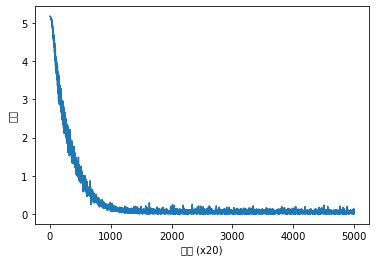

In [9]:
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [29]:
word_vecs = model.word_vecs
word_lst = []
for word_id, word in id_to_word.items():
#     print(word, word_vecs[word_id])
    word_lst.append(word)
word_vecs

array([[ 4.214551  ,  3.765166  ,  2.4744189 , ...,  3.6997364 ,
         0.00698677,  4.581368  ],
       [ 0.9015781 ,  2.6346867 , -0.78663176, ..., -0.902161  ,
         1.9160813 ,  1.3415918 ],
       [ 4.5973487 ,  4.9708924 ,  1.8773767 , ...,  4.442213  ,
        -5.2544947 ,  0.89950716],
       ...,
       [ 0.26566228,  6.275387  , -0.7526582 , ..., -5.930669  ,
        -3.9571316 , -0.27998635],
       [-5.270433  , -2.4564044 ,  4.754161  , ...,  5.534771  ,
        -1.4476475 , -3.8481386 ],
       [ 4.2164593 ,  2.5421846 , -4.7745547 , ..., -2.681558  ,
        -5.566286  , -2.5595589 ]], dtype=float32)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(word_vecs, word_vecs)
cosine_sim

array([[ 0.99999994,  0.25253057,  0.4315776 , ..., -0.31248054,
        -0.20257261, -0.11952019],
       [ 0.25253057,  1.0000002 ,  0.21475118, ...,  0.36372325,
        -0.15581684, -0.03002175],
       [ 0.4315776 ,  0.21475118,  1.0000001 , ...,  0.38980305,
         0.27432853,  0.16321592],
       ...,
       [-0.31248054,  0.36372325,  0.38980305, ...,  1.0000001 ,
         0.02664437,  0.4303751 ],
       [-0.20257261, -0.15581684,  0.27432853, ...,  0.02664437,
         1.0000001 , -0.26876965],
       [-0.11952019, -0.03002175,  0.16321592, ...,  0.4303751 ,
        -0.26876965,  1.        ]], dtype=float32)

In [18]:
cosine_sim.shape

(177, 177)

In [31]:
# id_to_word.items()

In [32]:
import pandas as pd
df = pd.DataFrame(cosine_sim, columns = word_lst, index = word_lst)
df

,you,say,goodbye,and,i,hello,.해외의,미디어,그룹들이,기후변화에,...,환경에,적극적인,대응은,제품,증가와,"함께,",라이프스타일과,높은,기대를,반영하고
you,1.000000,0.252531,0.431578,0.093202,0.294821,0.974063,0.004914,0.312411,0.032540,0.276979,...,0.276630,0.139027,0.252755,-0.108494,-0.251199,-0.271376,-0.227024,-0.312481,-0.202573,-0.119520
say,0.252531,1.000000,0.214751,0.491271,0.218443,0.231925,0.494395,-0.105384,-0.181102,0.249227,...,0.320019,0.522515,-0.038316,-0.013656,0.149933,-0.027430,-0.237323,0.363723,-0.155817,-0.030022
goodbye,0.431578,0.214751,1.000000,0.306510,0.982157,0.547786,-0.101454,-0.233199,0.280687,-0.482909,...,0.330808,0.297370,-0.303443,-0.315440,0.126721,0.462395,0.147243,0.389803,0.274329,0.163216
and,0.093202,0.491271,0.306510,1.000000,0.287714,0.166369,-0.416592,0.419500,-0.106797,-0.080459,...,0.105695,0.201433,-0.170377,-0.114016,0.134300,0.110370,0.327701,0.182428,0.109952,-0.241680
i,0.294821,0.218443,0.982157,0.287714,1.000000,0.401560,-0.045091,-0.368737,0.332500,-0.527984,...,0.352636,0.276201,-0.357188,-0.253032,0.232844,0.570934,0.107630,0.461010,0.262666,0.262081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"함께,",-0.271376,-0.027430,0.462395,0.110370,0.570934,-0.236072,0.080048,-0.550491,-0.048131,-0.360956,...,0.184930,0.234917,-0.299782,-0.109980,0.410019,1.000000,-0.150399,0.201923,0.007044,0.290029
라이프스타일과,-0.227024,-0.237323,0.147243,0.327701,0.107630,-0.066384,-0.674501,0.312301,0.024741,-0.437469,...,-0.231743,-0.195757,-0.288664,-0.236648,-0.499637,-0.150399,1.000000,0.418738,0.219590,-0.316199
높은,-0.312481,0.363723,0.389803,0.182428,0.461010,-0.225826,0.055800,-0.462082,0.031640,-0.537184,...,0.259465,0.322343,-0.747402,0.052434,-0.001233,0.201923,0.418738,1.000000,0.026644,0.430375
기대를,-0.202573,-0.155817,0.274329,0.109952,0.262666,-0.067868,-0.104238,0.051868,0.298004,-0.383943,...,-0.444378,-0.025272,0.076236,-0.549231,0.367669,0.007044,0.219590,0.026644,1.000000,-0.268770


In [43]:
def cos_max(word, df):
    return df[word].sort_values(ascending=False)
cos_max("자동차", df)

자동차      1.000000
제품       0.881129
종합적으로    0.707197
기업이      0.704376
예상됩니다    0.702201
           ...   
일간지들의   -0.663386
일간지들이   -0.704622
기대를     -0.716440
업무용     -0.750706
보면서,    -0.765679
Name: 자동차, Length: 177, dtype: float32